In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, TensorDataset
from transformers import  AdamW
from torch.nn import TransformerEncoder, TransformerEncoderLayer
import pandas as pd
import numpy as np
import spacy
import re
import math
import gc
from sklearn.model_selection import train_test_split as tts
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import PCA
from transformers import BertTokenizer
import ast
from torch.nn.utils.rnn import pad_sequence
import os
import matplotlib.pyplot as plt

In [20]:
class PositionalEncoding(nn.Module):
    """
    Positional Encoding module for Transformer models.

    Args:
        d_model (int): The number of expected features in the input.
        max_len (int, optional): The maximum length of the input sequence. Default is 23187.

    Attributes:
        dropout (nn.Dropout): Dropout layer.
        pe (torch.Tensor): Positional encoding tensor.

    """

    def __init__(self, d_model, max_len=23187):
        super(PositionalEncoding, self).__init__()
        self.dropout = nn.Dropout(p=0.1)

        pe = torch.zeros((max_len, d_model)) 
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0).transpose(0, 1)
        self.register_buffer('pe', pe)

    def forward(self, x):
        """
        Forward pass of the PositionalEncoding module.

        Args:
            x (torch.Tensor): Input tensor.

        Returns:
            torch.Tensor: Output tensor after adding positional encoding and applying dropout.

        """
        x = x + self.pe[:x.size(0), :]
        return self.dropout(x)


class TransformerTextClassifier(nn.Module):
    """
    Transformer-based Text Classifier.

    Args:
        ntoken (int): The number of unique tokens in the input.
        ninp (int): The number of expected features in the input.
        nhead (int): The number of heads in the multiheadattention models.
        nhid (int): The dimension of the feedforward network model.
        nlayers (int): The number of sub-encoder-layers in the encoder.
        num_classes (int): The number of classes for classification.
        dropout (float, optional): The dropout value. Default is 0.5.
        norm_first (bool, optional): Whether to apply layer normalization before the first encoder layer. Default is True.

    Attributes:
        pos_encoder (PositionalEncoding): PositionalEncoding module.
        transformer_encoder (nn.TransformerEncoder): TransformerEncoder module.
        encoder (nn.Embedding): Embedding layer.
        ninp (int): The number of expected features in the input.
        fc (nn.Linear): Linear layer for classification.
        activation (nn.GELU): Activation function.

    """

    def __init__(self, ntoken, ninp, nhead, nhid, nlayers, num_classes, dropout=0.5, norm_first=True):
        super(TransformerTextClassifier, self).__init__()
        self.activation = nn.GELU() 
        self.pos_encoder = PositionalEncoding(ninp)
        encoder_layers = nn.TransformerEncoderLayer(ninp, nhead, nhid, dropout, norm_first=norm_first, activation='gelu')
        self.transformer_encoder = nn.TransformerEncoder(encoder_layers, nlayers)
        self.encoder = nn.Embedding(ntoken, ninp)
        self.ninp = ninp
        self.fc = nn.Linear(ninp, num_classes-1)

        self.init_weights()

    def forward(self, src, src_mask):
        """
        Forward pass of the TransformerTextClassifier module.

        Args:
            src (torch.Tensor): Input tensor.
            src_mask (torch.Tensor): Mask tensor for the input.

        Returns:
            torch.Tensor: Output tensor after classification.

        """
        src = self.encoder(src) * math.sqrt(self.ninp)
        src = self.pos_encoder(src)
        output = self.transformer_encoder(src, src_mask)
        output = output.mean(dim=1)  # Pooling layer (e.g., mean pooling)
        output = self.fc(output)
        return output

    def init_weights(self):
        """
        Initialize the weights of the model.

        """
        initrange = 0.1
        for m in self.modules():
            if isinstance(m, nn.Linear):
                nn.init.xavier_uniform_(m.weight, gain=nn.init.calculate_gain('relu'))
                m.bias.data.zero_()


In [3]:
nlp = spacy.load("en_core_web_sm")
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

In [10]:
def preprocess_text(txt:str):
    """
    Preprocesses the input text by removing non-alphabetic characters, converting to lowercase,
    removing stopwords and punctuation, and lemmatizing the remaining tokens.

    Args:
        txt (str): The input text to be preprocessed.

    Returns:
        str: The preprocessed text.
    """

    txt = re.sub('[^a-zA-Z]', ' ', txt)
    txt = txt.lower()
    txt = " ".join(txt.split())

    doc = nlp(txt)

    tokens_filtered = []

    for token in doc:
        if token.is_stop or token.is_punct:
            continue

        tokens_filtered.append(token.lemma_)

    return " ".join(tokens_filtered)
def preprocess_labels(data):
    """
    Preprocesses the labels in the given data.

    Args:
        data (pandas.DataFrame): The input data containing the 'label' column.

    Returns:
        pandas.DataFrame: The input data with an additional 'label_prep' column, where the labels are mapped to unique IDs.
    """
    LABELS = data['label'].unique()
    label2id = dict(zip(LABELS, np.arange(len(LABELS), dtype=np.float32)))
    data['label_prep'] = data['label'].map(label2id)
    return data

def tokenize_and_convert(text):
    # Tokenize the text using spaCy
    spaCy_tokens = [token.text for token in nlp(text)]
    
    # Convert spaCy tokens to strings
    token_strings = [str(token) for token in spaCy_tokens]
    
    # Map token strings to numerical IDs using the pre-trained tokenizer
    token_ids = tokenizer.convert_tokens_to_ids(token_strings)
    
    return token_ids


In [7]:
# Load the CSV file
data = pd.read_csv('mental-health.csv')
# Display the first few rows of the DataFrame
print(data.head())
data = data.drop_duplicates(ignore_index = True)
df_null_values = data.isnull().sum().to_frame().rename(columns = {0:'count'})
df_null_values['%'] = (df_null_values['count'] / len(data)) * 100
print("")
print("df_null_values")
df_null_values



                                                text         label
0  I recently went through a breakup and she said...    depression
1  I do not know how to navigate these feelings, ...    depression
2  So I have been with my bf for 5 months , and h...    depression
3  I am so exhausted of this. Just when I think I...  SuicideWatch
4  I have been severly bullied since i was 5 till...    depression

df_null_values


,count,%
text,0,0.0
label,0,0.0


In [8]:
# apply the preprocess_text function to the 'text' column
data['text_prep'] = data['text'].apply(preprocess_text)


In [6]:
#apply the tokenize_and_convert function to the 'text_prep' column
data['token_id'] =  data['text_prep'].apply(tokenize_and_convert)

In [11]:
preprocessed_data = preprocess_labels(data)
print(preprocessed_data.head())


                                                text         label  \
0  I recently went through a breakup and she said...    depression   
1  I do not know how to navigate these feelings, ...    depression   
2  So I have been with my bf for 5 months , and h...    depression   
3  I am so exhausted of this. Just when I think I...  SuicideWatch   
4  I have been severly bullied since i was 5 till...    depression   

                                           text_prep  label_prep  
0  recently go breakup say want friend say try ta...         0.0  
1  know navigate feeling new feeling stretch unde...         0.0  
2  bf month tell depressed week particular happen...         0.0  
3  exhausted think finally rest think maybe thing...         1.0  
4  severly bully till result depressed misanthrop...         0.0  


In [12]:
# Drop rows with null values in the 'text_prep' column.
data.dropna(subset=['text_prep'], inplace=True)

In [9]:
data.to_csv('preprocessed_data.csv', index=False)

After preprocessed data once, load the saved data from csv file:

In [4]:
data = pd.read_csv('preprocessed_data.csv')

In [35]:
# data[data['token_id'].isna()]['token_id'].head()
# data['token_id'] = data['token_id'].fillna('[]')

In [5]:
def convert_string_to_array(s):
    return np.array(ast.literal_eval(s))

data['token_id']  = data['token_id'] .apply(convert_string_to_array)


In [91]:
data.head()

,text,label,text_prep,token_id,label_prep
0,I recently went through a breakup and she said...,depression,recently go breakup say want friend say try ta...,"[3728, 2175, 19010, 2360, 2215, 2767, 2360, 30...",0.0
1,"I do not know how to navigate these feelings, ...",depression,know navigate feeling new feeling stretch unde...,"[2113, 22149, 3110, 2047, 3110, 7683, 3305, 27...",0.0
2,"So I have been with my bf for 5 months , and h...",depression,bf month tell depressed week particular happen...,"[28939, 3204, 2425, 14777, 2733, 3327, 4148, 2...",0.0
3,I am so exhausted of this. Just when I think I...,SuicideWatch,exhausted think finally rest think maybe thing...,"[9069, 2228, 2633, 2717, 2228, 2672, 2518, 270...",1.0
4,I have been severly bullied since i was 5 till...,depression,severly bully till result depressed misanthrop...,"[100, 20716, 6229, 2765, 14777, 100, 100, 3674...",0.0


In [93]:
%pip install tabulate
data_head_table = data.head().to_markdown()
with open('data_head_table.md', 'w') as f:
    f.write(data_head_table)


Note: you may need to restart the kernel to use updated packages.


In [7]:
X = data['token_id']
y = data['label_prep']


SEED = 1235
train_ids_0, test_ids, train_labels_0, test_labels = tts(X, y, test_size = 0.1, random_state = SEED)
train_ids, val_ids, train_labels, val_labels = tts(train_ids_0, train_labels_0, test_size = 0.2, random_state = SEED)

In [29]:
# Train Hyperparameters
num_attention_heads = int(np.random.uniform(2, 4))
embedding_size = int(np.random.uniform(120, 170))
             # ninp = embedding_size
embedding_size = embedding_size - embedding_size % num_attention_heads
nhidden = int(np.random.uniform(50, 300))
nlayers = int(np.random.uniform(2, 12))
Dropout = np.random.uniform(0.1, 0.12)
learning_rate = np.random.uniform(1e-3, 0.01)


# Chosen Hyperparameters
embedding_size = 152
num_attention_heads = 8
nhidden = 70
nlayers = 4
criterion = nn.BCEWithLogitsLoss() 
learning_rate = 3e-3
num_epochs = 4
batch_size = 32


In [30]:

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# torch.cuda.set_device(1)


In [31]:
ntoken= 37585 # the size of vocabulary after tokenization
val_labels_array = val_labels.values.astype(float)
test_labels_array = test_labels.values.astype(float)

# Pad the sequences to create a tensor of shape (batch_size, max_seq_length)
padded_train = pad_sequence([torch.tensor(seq) for seq in train_ids], batch_first=True, padding_value=0)
padded_val = pad_sequence([torch.tensor(seq) for seq in val_ids], batch_first=True, padding_value=0)
padded_test = pad_sequence([torch.tensor(seq) for seq in test_ids], batch_first=True, padding_value=0)

# Create DataLoader objects for the training, validation, and test sets
train_dataset = TensorDataset(torch.tensor(padded_train, dtype=torch.float), torch.tensor(train_labels, dtype=torch.float))
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

val_dataset = TensorDataset(torch.tensor(padded_val, dtype=torch.float), torch.tensor(val_labels_array, dtype=torch.float))
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

test_dataset =TensorDataset(torch.tensor(padded_test, dtype=torch.float), torch.tensor(test_labels_array, dtype=torch.float))


/tmp/ipykernel_2760112/793104445.py:11: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_dataset = TensorDataset(torch.tensor(padded_train, dtype=torch.float), torch.tensor(train_labels, dtype=torch.float))
/tmp/ipykernel_2760112/793104445.py:14: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_dataset = TensorDataset(torch.tensor(padded_val, dtype=torch.float), torch.tensor(val_labels_array, dtype=torch.float))
/tmp/ipykernel_2760112/793104445.py:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  test_dataset =TensorDataset(torch.tens

In [33]:
# Print the hyperparameters
print("Hyperparameters:")
print(f"num_attention_heads= {num_attention_heads}")
print(f"embedding_size= {embedding_size}")
print(f"nhidden= {nhidden}")
print(f"nlayers= {nlayers}")
print(f"dropout= {Dropout}")
print("criterion=", criterion)
print(f"learning_rate= {learning_rate}")
print(f"num_epochs= {num_epochs}")
print(f"batch_size= {batch_size}")
print(f"ntoken= {ntoken}")

Hyperparameters:
num_attention_heads= 2
embedding_size= 124
nhidden= 101
nlayers= 7
dropout= 0.10263072196005447
criterion= BCEWithLogitsLoss()
learning_rate= 0.0017226710513919786
num_epochs= 4
batch_size= 32
ntoken= 37585


In [34]:
# model = TransformerModel(ntoken, embedding_size, num_attention_heads, nhidden, nlayers, Dropout, norm_first=True).to(device)
model = TransformerTextClassifier( ntoken, embedding_size, num_attention_heads, nhidden, nlayers,2, Dropout, norm_first=True).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [35]:
losses =[]
train_accuracies = []

for epoch in range(num_epochs):
    model.train()
    total_correct=0.0
    total_samples=0.0
    if epoch == 1:
        optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate/10)
    if epoch == 3:
        optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate/15)
    for batch_idx, (texts, labels) in enumerate(train_loader):
        model.train()
        # Convert texts and labels to tensors if necessary
        texts = texts.to(device).long()  
        labels = labels.to(device)

        
        optimizer.zero_grad()
        outputs = model(texts, None)
        loss = criterion(outputs.squeeze(), labels.float())
        loss.backward()
        optimizer.step()

        outputs = torch.sigmoid(outputs) 
        predictions = (outputs > 0.5).float()
        total_correct += (predictions[:,0] == labels).sum().item()
        total_samples += labels.size(0)
        
        if batch_idx % 20 == 0 and batch_idx > 0:
            accuracy = total_correct / total_samples
            losses.append(loss.item())
            train_accuracies.append(accuracy)
            print(f"Epoch [{epoch+1}/{num_epochs}], Batch [{batch_idx+1}/{len(train_loader)}], Loss: {loss.item():.3f}, train_acc: {100. * accuracy:.2f}%")
            total_correct = 0.0
            total_samples = 0.0

 
    # Validation
    model.eval()
    with torch.no_grad():
        total_correct = 0
        total_samples = 0
        for texts, labels in val_loader:
            texts = texts.to(device).long()  
            labels = labels.to(device)
            outputs = model(texts, None)
            outputs = torch.sigmoid(outputs) 
            predictions = (outputs > 0.5).float()
            total_correct += (predictions[:,0] == labels).sum().item()
            total_samples += labels.size(0)
            accuracy = total_correct / total_samples
    print(f'total_correct {total_correct}, total_samples : {total_samples}, Val Acc: {100. * accuracy:.2f}%')



Epoch [1/4], Batch [21/458], Loss: 2.424, train_acc: 48.07%
Epoch [1/4], Batch [41/458], Loss: 1.600, train_acc: 51.25%
Epoch [1/4], Batch [61/458], Loss: 0.743, train_acc: 52.50%
Epoch [1/4], Batch [81/458], Loss: 1.416, train_acc: 43.91%
Epoch [1/4], Batch [101/458], Loss: 1.333, train_acc: 50.78%


KeyboardInterrupt: 

In [ ]:
import math
def accurary_est(y_pred, y_label):
  y_pred = [0 if torch.sigmoid(i) < 0.5 else 1 for i in torch.tensor(y_pred)]
  return sum([1 for res in range(len(y_pred)) if y_pred[res] == y_label[res]]) / len(y_pred)

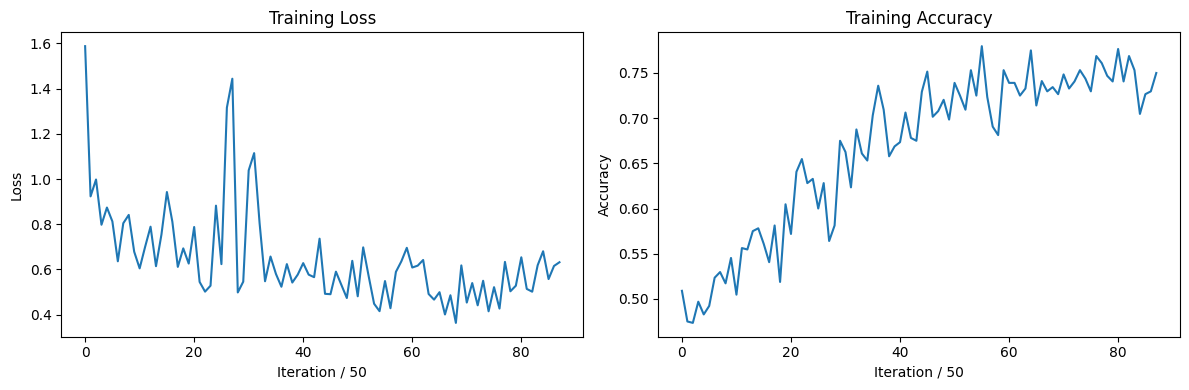

In [24]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

# Plot losses
ax1.plot(losses)
ax1.set_xlabel('Iteration / 50')
ax1.set_ylabel('Loss')
ax1.set_title('Training Loss')

# Plot train accuracies
ax2.plot(train_accuracies)
ax2.set_xlabel('Iteration / 50')
ax2.set_ylabel('Accuracy')
ax2.set_title('Training Accuracy')

plt.tight_layout()
plt.show()



In [23]:
# Save the model
torch.save(model.state_dict(), 'model_checkpoint12.pth')

In order to evaluate test set on saved model use uncomment following, and make sure all model hyperparams are the same as the corresponding config file:

In [36]:
# ## run on a pretrained checkpoint: 
num_attention_heads= 8
embedding_size= 152
nhidden= 70
nlayers= 4
dropout= 0.118761850455772
learning_rate= 0.003
num_epochs= 4
batch_size= 32
ntoken= 37585
model = TransformerTextClassifier( ntoken, embedding_size, num_attention_heads, nhidden, nlayers,2, Dropout, norm_first=True).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

checkpoint = torch.load("model_checkpoint10.pth")
model.load_state_dict(checkpoint)

<All keys matched successfully>

In [88]:
# Final training results
model.eval()
train_predictions = []
train_lables = []
with torch.no_grad():
    total_correct = 0
    total_samples = 0
    for texts, labels in train_loader:
        train_lables.extend(labels.tolist())
        texts = texts.to(device).long()  
        labels = labels.to(device)
        outputs = model(texts, None)
        outputs = torch.sigmoid(outputs) 
        train_predictions.extend((outputs > 0.5).float().tolist())
        # total_correct += (predictions[:,0] == labels).sum().item()
        # total_samples += labels.size(0)
        # accuracy = total_correct / total_samples
        # print(predictions[:,0])
        # print(f'total_correct [{predictions.shape}, total_samples : {labels.shape}')
# print(f'total_correct {total_correct}, total_samples : {total_samples}, Val Acc: {100. * accuracy:.2f}%')

In [17]:
# Validation
model.eval()
with torch.no_grad():
    total_correct = 0
    total_samples = 0
    for texts, labels in val_loader:
        texts = texts.to(device).long()  
        labels = labels.to(device)
        outputs = model(texts, None)
        outputs = torch.sigmoid(outputs) 
        predictions = (outputs > 0.5).float()
        total_correct += (predictions[:,0] == labels).sum().item()
        total_samples += labels.size(0)
        accuracy = total_correct / total_samples
        # print(predictions[:,0])
        # print(f'total_correct [{predictions.shape}, total_samples : {labels.shape}')
print(f'total_correct {total_correct}, total_samples : {total_samples}, Val Acc: {100. * accuracy:.2f}%')

total_correct 2600, total_samples : 3663, Val Acc: 70.98%


In [89]:
# Test results
model.eval()
test_predictions = []
test_lables = []
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
with torch.no_grad():
    total_correct = 0
    total_samples = 0

    for texts, labels in test_loader:
        test_lables.extend(labels.tolist())
        texts = texts.to(device).long()  
        labels = labels.to(device)
        outputs = model(texts, None)
        outputs = torch.sigmoid(outputs) 
        test_predictions.extend((outputs > 0.5).float().tolist())
        # total_correct += (predictions[:,0] == labels).sum().item()
        # total_samples += labels.size(0)
        # accuracy = total_correct / total_samples
print(f' test Acc: {100. * accuracy:.2f}%')

 test Acc: 49.38%


In [ ]:
%pip install seaborn
import seaborn as sns
from sklearn.metrics import confusion_matrix

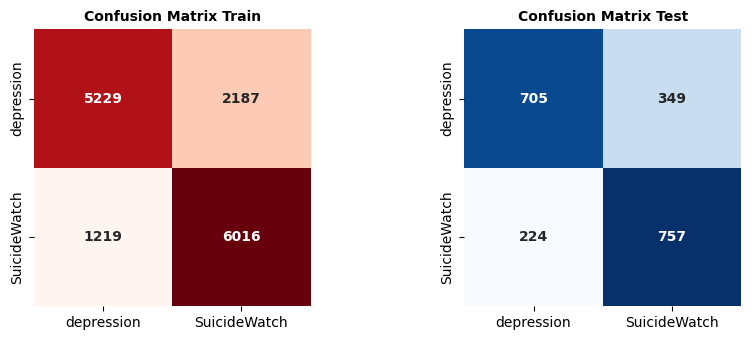

In [90]:

cf_mx_train = confusion_matrix(train_lables, train_predictions)
cf_mx_test = confusion_matrix(test_lables, test_predictions)
LABELS = data['label'].unique()

fig,ax = plt.subplots(nrows = 1, ncols = 2, figsize = (9,3.5))

sns.heatmap(cf_mx_train, cmap = 'Reds', 
            fmt = '', annot = True, cbar = False, 
            annot_kws = {'fontsize':10, 'fontweight':'bold'},
            square = True, xticklabels = LABELS, yticklabels = LABELS, ax = ax[0])

sns.heatmap(cf_mx_test, cmap = 'Blues', 
            fmt = '', annot = True, cbar = False, 
            annot_kws = {'fontsize':10, 'fontweight':'bold'},
            square = True, xticklabels = LABELS, yticklabels = LABELS, ax = ax[1])

ax[0].set_title("Confusion Matrix Train", fontsize = 10, fontweight = "bold", color = "black")
ax[1].set_title("Confusion Matrix Test", fontsize = 10, fontweight = "bold", color = "black")
fig.tight_layout()
fig.show()

In [ ]:
def deallocate_tensors():
    for obj in gc.get_objects():
        if torch.is_tensor(obj) :
            if obj.device.type == 'cuda':
                del obj  # This removes the reference to the tensor
    torch.cuda.empty_cache()  # This releases any remaining GPU memory not in use

deallocate_tensors()



In [ ]:
print(torch.cuda.memory_reserved()/(1024 ** 3))

# Release cached memory
torch.cuda.empty_cache()
gc.collect()

# After releasing cached memory
print(torch.cuda.memory_reserved()/(1024 ** 3))

In [18]:

def check_gpu_capacity():
    if torch.cuda.is_available():
        device = torch.device("cuda")
        properties = torch.cuda.get_device_properties(device)
        total_memory = properties.total_memory / (1024 ** 3)  # Convert bytes to gigabytes
        memory_allocated = torch.cuda.memory_allocated(device) / (1024 ** 3)  # Allocated memory in use
        memory_cached = torch.cuda.memory_reserved(device) / (1024 ** 3)  # Cached but not currently in use
        free_memory = total_memory - memory_allocated - memory_cached
        print(f"Total GPU Memory: {total_memory:.2f} GB")
        print(f"Allocated Memory: {memory_allocated:.2f} GB")
        print(f"Cached Memory: {memory_cached:.2f} GB")
        print(f"Free Memory: {free_memory:.2f} GB")
    else:
        print("CUDA is not available.")

check_gpu_capacity()


Total GPU Memory: 10.91 GB
Allocated Memory: 0.06 GB
Cached Memory: 0.14 GB
Free Memory: 10.71 GB
